##Import Library

In [149]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (jaccard_score, roc_auc_score, recall_score, precision_score, f1_score,
                             balanced_accuracy_score, accuracy_score, PredictionErrorDisplay, RocCurveDisplay,
                             confusion_matrix, ConfusionMatrixDisplay)

##Import Dataset

In [150]:
from google.colab import drive

# 1. Hubungkan Google Drive (langkah ini wajib jika notebook baru dibuka)
drive.mount('/content/drive')

# 2. Gunakan path yang BENAR untuk file di Google Drive Anda
#    Bukan path dari Kaggle.
file_path_benar = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/Student Depression Dataset.csv'

# 3. Baca file menggunakan path yang sudah diperbaiki
try:
    df_in = pd.read_csv(file_path_benar)

    # Tampilkan beberapa baris untuk memastikan berhasil
    print("✔️ Berhasil! Dataset sudah dimuat ke dalam variabel 'df_in'.")
    print(df_in.head())

except FileNotFoundError:
    print("❌ Gagal! File tetap tidak ditemukan. Pastikan path sudah 100% benar dan tidak ada salah ketik.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔️ Berhasil! Dataset sudah dimuat ke dalam variabel 'df_in'.
   id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

      Sleep Dura

In [151]:
# def's for research
def f_overview_print(df):
    print(df.head())  # print 5 rows of dataframe
    print(df.info())  # print columns and types
    print(df.isna().sum())  # print NAN
    print(df.isnull().sum())
    print(df.describe())
    print(df.dtypes)

def f_add_column_new(df, column_old: [str, list], column_new: str, action: str):
    """In: dataframe; Out: dataframe; Step: add new column, merge several columns and create a new one, create empty
    column"""
    df_out = df.copy()
    if action == 'add':
        df_out[column_new] = df_out[column_old].sum(axis=1)
        df_out.drop(columns=column_old, axis=1, inplace=True)
        return df_out
    elif action == 'merge':
        df_out[column_new] = ''
        for _ in column_old:
            df_out[column_new] = df_out[column_new] + df_out[_].astype(str)
        return df_out
    elif action == 'create':
        df_out[column_new] = ''
        return df_out


def f_get_unique_val(df, col_name):
    """In: str; Out: list; Step: return unique values in selected column"""
    if type(col_name) is str:
        return list(df[col_name].unique())


def f_string_manipulation(df, column_name: list, action: str):
    """In: dataframe; Out: dataframe; Step: replace values in column by new value"""
    df_out = df.copy()
    for _ in column_name:
        if action == 'upper':
            df_out[_] = df_out[_].str.upper()
        if action == 'lower':
            df_out[_] = df_out[_].str.lower()
    return df_out


def f_change_column_name_register(df, type_name):
    df_temp = df.copy()
    df_out = df_temp.copy()
    lst_new = []
    for _ in list(df_temp.columns):
        lst_new.append(type_name(_).lower())
    df_out.columns = lst_new
    return df_out


def f_filter_rows_2(df, column_name, value_filter, action):
    """In: dataframe; Out: dataframe; Step: drop / show rows by condition"""
    if action == 'drop':
        df_out = df.drop(df[df[column_name] == value_filter].index)
        return df_out
    if action == 'filter':
        df_out = df[df[column_name] == value_filter]
        return df_out


def f_filter_columns(df, columns, action: str):
    """In: dataframe; Out: dataframe; Step: filter/drop out columns"""
    if action == 'filter':
        df_out = df.filter(columns)
        return df_out
    if action == 'drop':
        df_out = df.drop(columns, axis=1, inplace=False)
        return df_out


def f_get_avg_value(df, column_upd, calculation_mode):
    """In: dataframe; Out: dataframe; Step: check or update value for selected numeric column"""
    if calculation_mode == 'median':
        value_new = df[column_upd].median()
    elif calculation_mode == 'mean':
        value_new = df[column_upd].mean()
    elif calculation_mode == 'mode':
        value_new = df[column_upd].mode()[0]
    else:
        value_new = calculation_mode
    return value_new


def f_get_avg_value_2(df, column_key, column_upd, calculation_mode):
    """In: dataframe; Out: dataframe; Step: check or update value for numeric column
    column_upd --> column for update
    calculation_mode --> logic for new value calculation: median / mean / mode or value proposed by user"""
    if calculation_mode == 'median':
        df_temp_gr = df.groupby(column_key)[[column_upd]].median().reset_index()
    elif calculation_mode == 'mean':
        df_temp_gr = df.groupby(column_key)[[column_upd]].mean().reset_index()
    else:
        df_temp_gr = df
    return df_temp_gr


def f_fill_column_data(df, column_key: str, column_upd: str, value_old: [int, str], value_new_by: str):
    """In: dataframe; Out: dataframe; Step: check or update value for numeric column by average value, selected value
    included"""
    df_out = df.copy()
    lst_column_key_uniq = f_get_unique_val(df, column_key)
    for _ in lst_column_key_uniq:
        df_temp = f_filter_rows_2(df, column_key, _, 'filter')
        value_new = f_get_avg_value(df_temp, column_upd, value_new_by)
        if value_old == 0:  # Re-write 0 by new value
            df_out[column_upd] = np.where((df_out[column_upd] == 0) & (df_out[column_key] == _),
                                          value_new, df_out[column_upd])
        elif value_old == 'filled':  # Re-write existing value by new value
            df_out[column_upd] = np.where((df_out[column_key] == _),
                                          value_new, df_out[column_upd])
        elif value_old == '-':  # Re-write '-' by new value
            df_out[column_upd] = np.where((df_out[column_upd] == '-') & (df_out[column_key] == _),
                                          value_new, df_out[column_upd])
        elif value_old == ' ':  # Re-write '-' by new value
            df_out[column_upd] = np.where((df_out[column_upd] == ' ') & (df_out[column_key] == _),
                                          value_new, df_out[column_upd])
        elif type(value_old) is int:
            df_out[column_upd] = np.where((df_out[column_upd] == value_old) & (df_out[column_key] == _),
                                          value_new, df_out[column_upd])
    return df_out


def f_fill_column_data_5(df, column_key: str, column_upd: str, value_old: int, value_new_by: str,
                         action: str):
    """In: dataframe; Out: dataframe; Step: update value for numeric column by average value, selected values
    excluded"""
    df_out = df.copy()
    lst_uniq = []
    df_gr = f_filter_rows_2(df_out, column_upd, 0, 'drop')
    if action == 'ge':
        df_gr = df_gr.drop(df_gr[df_gr[column_upd] >= value_old].index)
        df_filter = df_out[df_out[column_upd] >= value_old]
        lst_uniq = list(df_filter[column_upd].unique())
    if action == 'g':
        df_gr = df_gr.drop(df_gr[df_gr[column_upd] > value_old].index)
        df_filter = df_out[df_out[column_upd] > value_old]
        lst_uniq = list(df_filter[column_upd].unique())
    if action == 'le':
        df_gr = df_gr.drop(df_gr[df_gr[column_upd] <= value_old].index)
        df_filter = df_out[df_out[column_upd] <= value_old]
        lst_uniq = list(df_filter[column_upd].unique())
    if action == 'l':
        df_gr = df_gr.drop(df_gr[df_gr[column_upd] < value_old].index)
        df_filter = df_out[df_out[column_upd] < value_old]
        lst_uniq = list(df_filter[column_upd].unique())
    df_temp_gr = f_get_avg_value_2(df_gr, column_key, column_upd, value_new_by)
    column_name = column_upd + '_AVG'
    df_temp_gr.rename(columns={str(column_upd): str(column_name)}, inplace=True)  # Rename column in aggregated df
    df_ = pd.merge(df_out, df_temp_gr, how='outer', on=column_key)
    for _ in lst_uniq:
        df_[column_upd] = np.where(((df_[column_upd] == _) & (df_[column_name] > 0)), df_[column_name],
                                   df_[column_upd])
    df_ = f_filter_columns(df_, [column_name], 'drop')  # Drop tech column
    df_out = df_.copy()
    return df_out


def f_replace_value(df, column_upd: list, value_old, value_new):
    """In: dataframe; Out: dataframe; Step: replace values in column by new value"""
    df_out = df.copy()
    for _ in column_upd:
        df_out[_].replace(value_old, value_new, inplace=True, regex=True)
    return df_out


def f_assign_decade(df, column_gr: str):
    """In: dataframe; Out: dataframe; Step: assign decade for year"""
    df_out = df.copy()
    df_out['group_' + str(column_gr)] = (df_out[column_gr] % 100) // 10
    return df_out


def f_split_column(df, column_old: str, column_new: list, is_drop_col_old: bool):
    """In: dataframe; Out: dataframe; Step: split 1 column into 2 by space"""
    df_out = df.copy()
    df_out[column_new] = df_out[column_old].str.split(' ', expand=True, n=1)
    if is_drop_col_old is True:
        df_out = f_filter_columns(df_out, column_old, 'drop')
    return df_out


def f_change_column_type(df, column_old: list, data_type):
    """In: dataframe; Out: dataframe; Step: change column type"""
    df_out = df.copy()
    for _ in column_old:
        df_out[_] = df_out[_].astype(data_type)
    return df_out


def f_assign_group_for_numeric(df, column_gr: str, cnt_group: int, limit: float, calculation_mode: str):
    """In: dataframe; Out: dataframe; Step: split rows to groups based on value"""
    df_out = df.copy()
    df_ = pd.DataFrame()
    gr_num = 0
    df_out['group_' + str(column_gr)] = 0
    while gr_num < cnt_group:
        val_uniq = sorted(df_out['group_' + str(column_gr)].unique())
        val_latest = df_out['group_' + str(column_gr)].max()
        for _ in val_uniq:
            df_temp = df_out[df_out['group_' + str(column_gr)] == _]
            value_avg = f_get_avg_value(df_temp, column_gr, calculation_mode) + limit
            val_next = val_latest + 1
            df_temp['group_' + str(column_gr)] = np.where((df_temp[column_gr] < value_avg), _, val_next)
            df_ = pd.concat([df_, df_temp], ignore_index=True)
            val_latest = val_latest + 1
        gr_num = gr_num + 1
        df_out = df_.copy()
        df_.drop(df_.index, inplace=True)
    return df_out


def f_get_df_types_2(df, is_numeric: bool):
    """In: dataframe; Out: dataframe; Step: get df with types"""
    if is_numeric is True:
        df_out = df.select_dtypes(include=['int', 'int64', 'float', 'float64', 'int32', 'float32'])
    else:
        df_out = df.select_dtypes(include=['object', 'string'])
    return list(df_out)


def f_encode_onehot_pd(df, column_old: list):
    """In: dataframe; Out: dataframe; Step: encode labels"""
    """Only for categorical labels < 2, for others f_encode_binary_labels"""
    df_out = df.copy()
    for _ in column_old:
        df_out = pd.get_dummies(df_out, columns=[_], dtype='int')
    return df_out


def f_encode_binary_labels(df, column_old):
    """In: dataframe; Out: dataframe; Step: encode labels"""
    """Only for categorical labels > 2, for others OneHot"""
    df_out = df.copy()
    for _ in column_old:
        lb = LabelBinarizer()
        lb.fit(df_out[_])
        transformed = lb.transform(df_out[_])
        ohe_df = pd.DataFrame(transformed, columns=lb.classes_, index=df_out.index)
        data = pd.concat([df_out, ohe_df], axis=1).drop([_], axis=1)
        df_out = data.copy()
    return df_out


def f_normalize_min_max(df, column_upd):
    """In: dataframe; Out: dataframe; Step: normalize values by min and max values"""
    df_out = df.copy()
    for _ in column_upd:
        df_out[_] = (df_out[_] - df_out[_].min()) / (df_out[_].max() - df_out[_].min())
    return df_out

In [152]:
# Def's for visual

def f_get_param_plot(str_title):
    plt.figure(figsize=(10, 10))
    plt.title(str_title, fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.set_theme(style="whitegrid", palette="Set2", font='sans-serif', font_scale=0.95)


def f_get_heatmap_plot(df, details):
    """In: dataframe; Out: heatmap plot"""
    try:
        str_title: str = 'Heatmap' + '_' + str(details)
        f_get_param_plot(str_title)
        sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True, fmt=".1f",
                    linewidth=.7, linecolor='white')
        plt.show()
    except Exception as e:
        print(f'Issue here, catch: {e}')

def f_get_hist_plot(df, hue):
    """In: dataframe; Out: hist plot; Step: save data"""
    try:
        str_title: str = 'Hist' + '_' + str(hue)
        f_get_param_plot(str_title)
        sns.histplot(df[hue], bins=20, binwidth=2, stat='count')
        plt.show()
    except Exception as e:
        print(f'Issue here, catch: {e}')

def f_get_scatter_plot(df, x, y, hue, details):
    """In: dataframe; Out: scatter plot; Step: save data"""
    try:
        str_title: str = 'Box' + '_' + str(x) + '_' + str(y) + '_' + str(hue) + '_' + str(details)
        f_get_param_plot(str_title)
        sns.scatterplot(data=df, x=x, y=y, hue=hue).set_title(str_title)
        plt.show()
    except Exception as e:
        print(f'Issue here, catch: {e}')

def f_prediction_error_display_upd(args):
    y = args[0]
    X = args[1]
    model = args[2]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    _ = PredictionErrorDisplay.from_estimator(model, X, y, kind="actual_vs_predicted", ax=axs[0])
    _ = PredictionErrorDisplay.from_estimator(model, X, y, kind="residual_vs_predicted", ax=axs[1])
    plt.show()

In [153]:
# def's for research
def f_overview_print(df):
    print(df.head())  # print 5 rows of dataframe
    print(df.info())  # print columns and types
    print(df.isna().sum())  # print NAN
    print(df.isnull().sum())
    print(df.describe())
    print(df.dtypes)

In [154]:
# Print overview df
f_overview_print(df_in)

   id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

      Sleep Duration Dietary Habits   Degree  \
0          5-6 hours        Healthy  B.Pharm   
1          5-6 hours       Moderate      BSc   
2  Less than 5 hours        Healthy       BA   
3          7-8

In [155]:
# Get numeric, non numeric columns

df_temp = df_in.copy()

lst_numeric_init = f_get_df_types_2(df_temp, is_numeric=True)
print(f'Numeric cols: {lst_numeric_init}')

lst_category_init = f_get_df_types_2(df_temp, is_numeric=False)
print(f'Non-numeric cols: {lst_category_init}')

Numeric cols: ['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']
Non-numeric cols: ['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


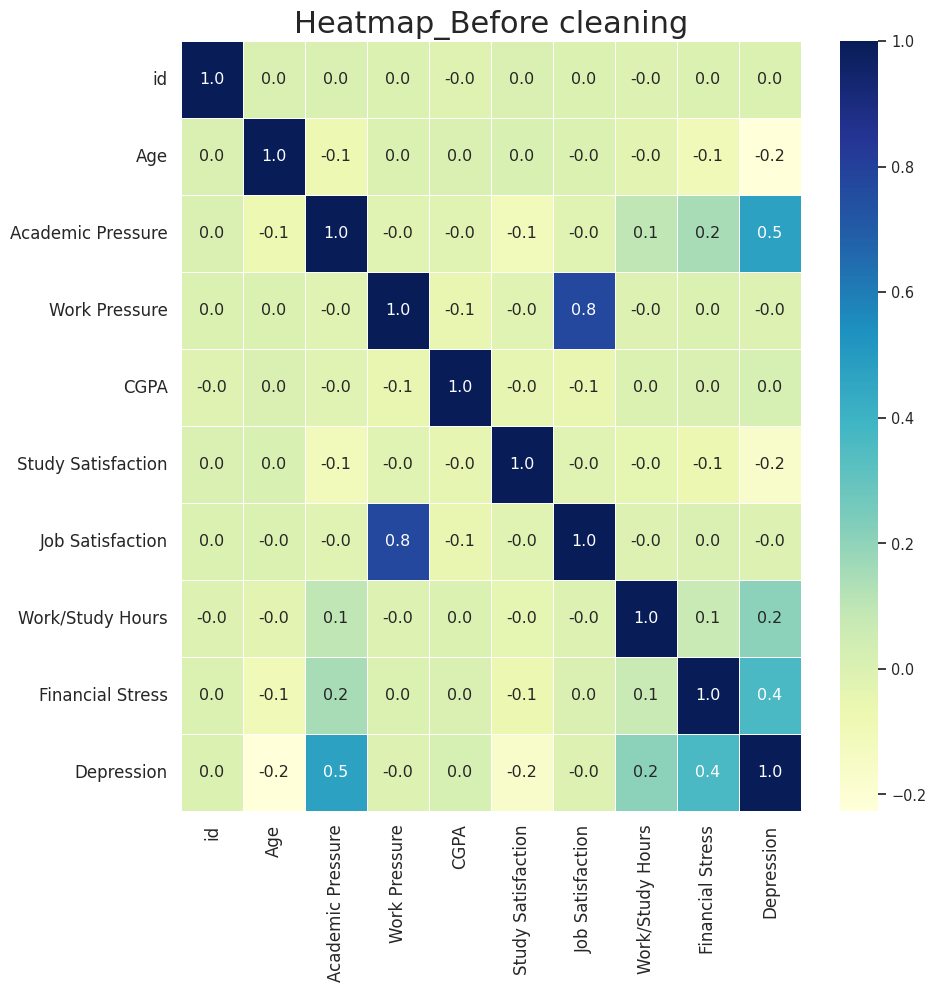

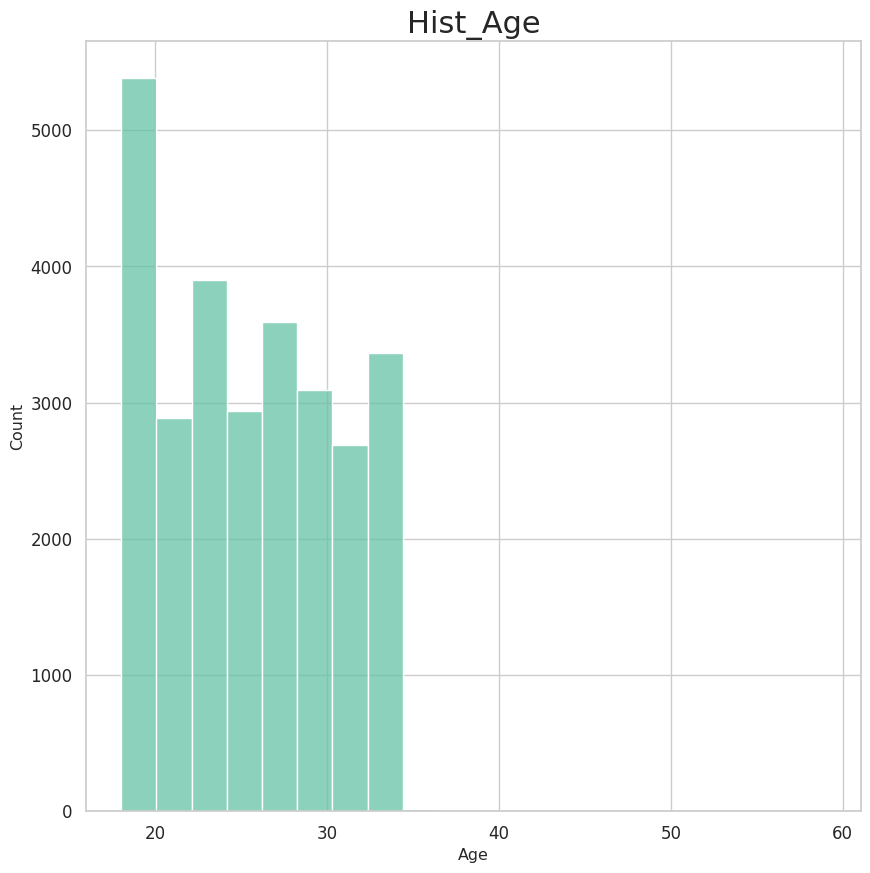

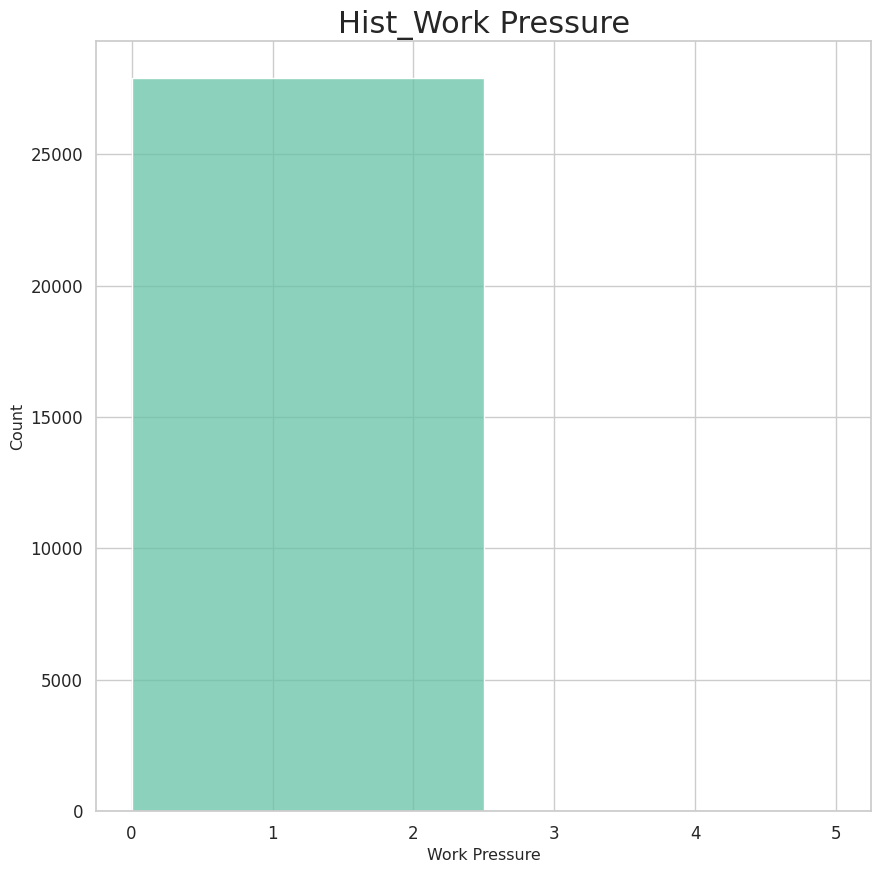

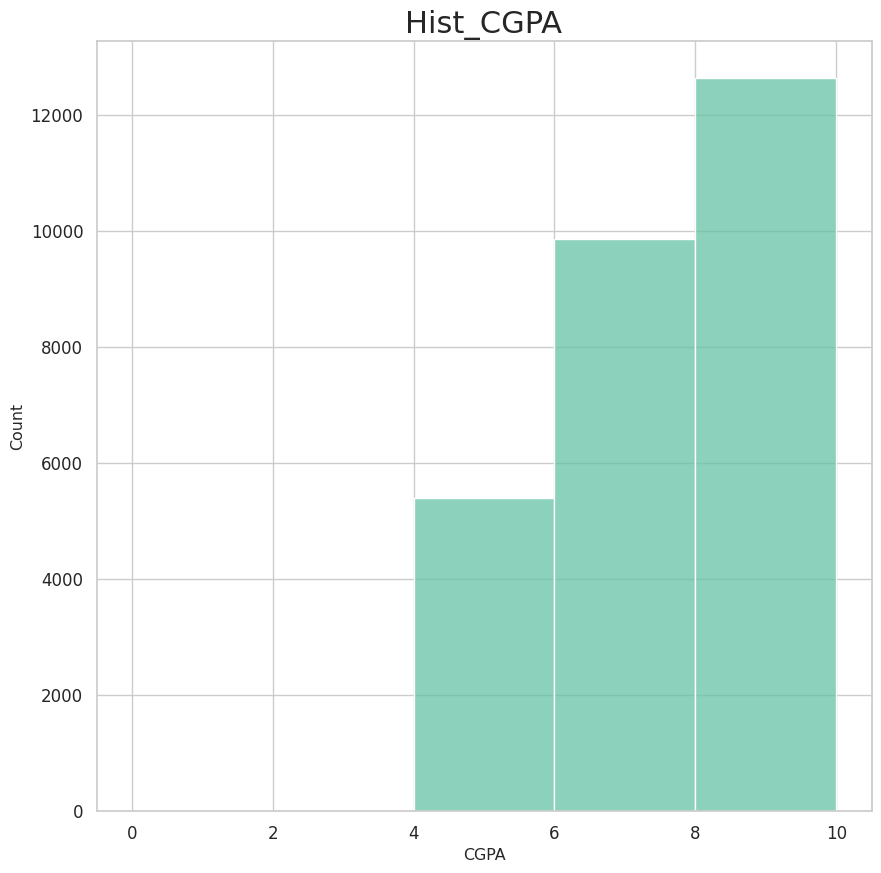

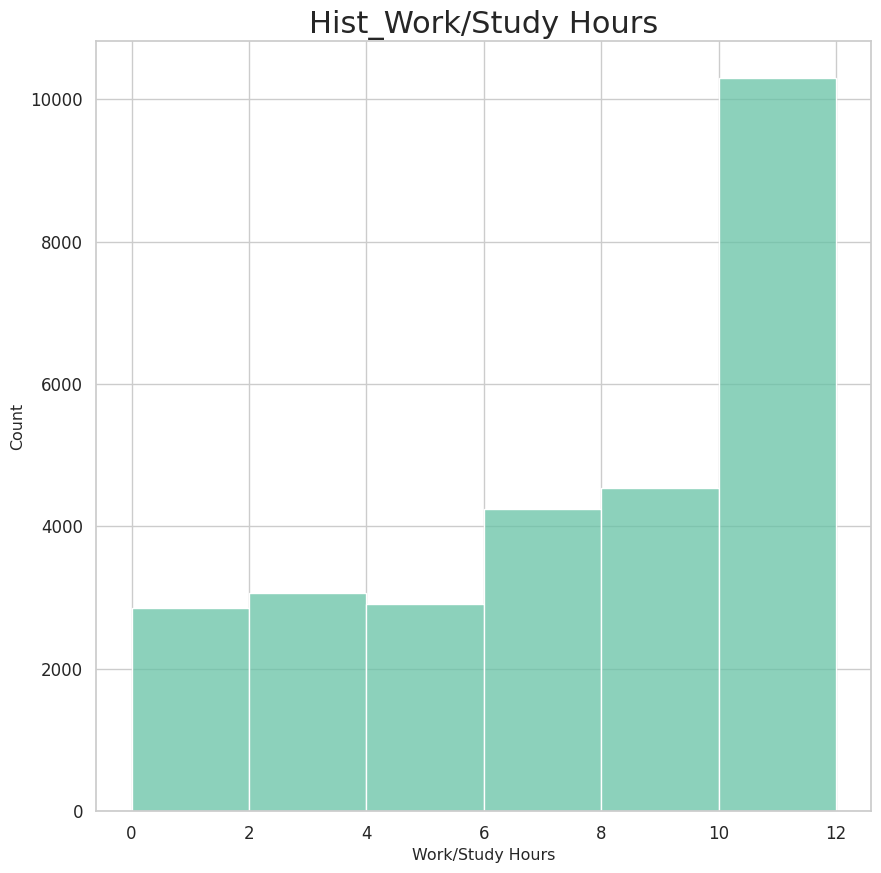

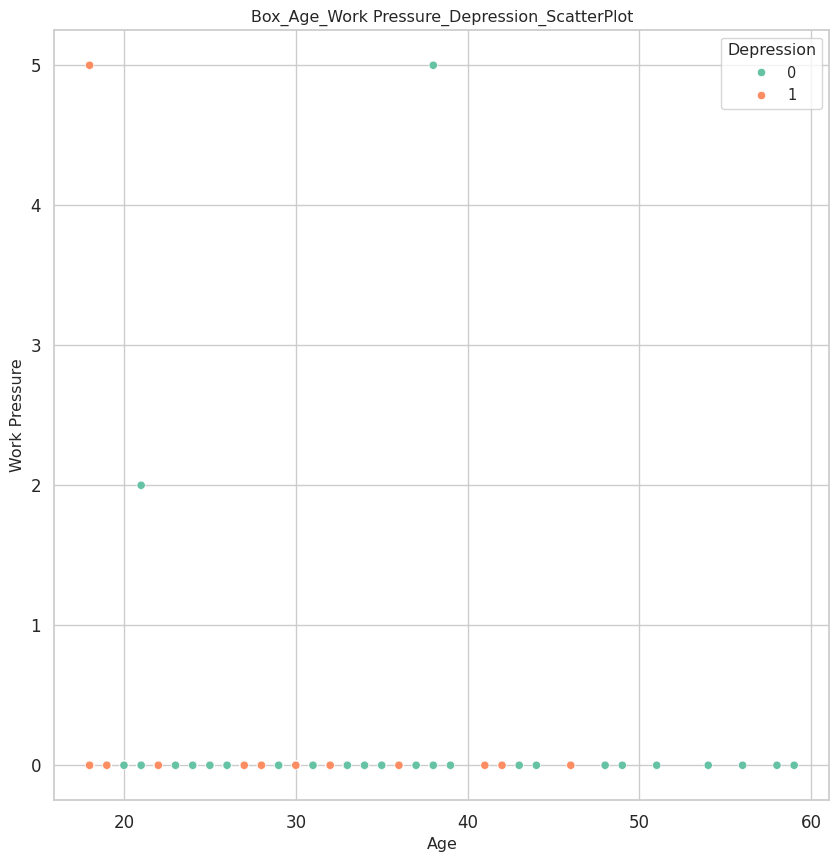

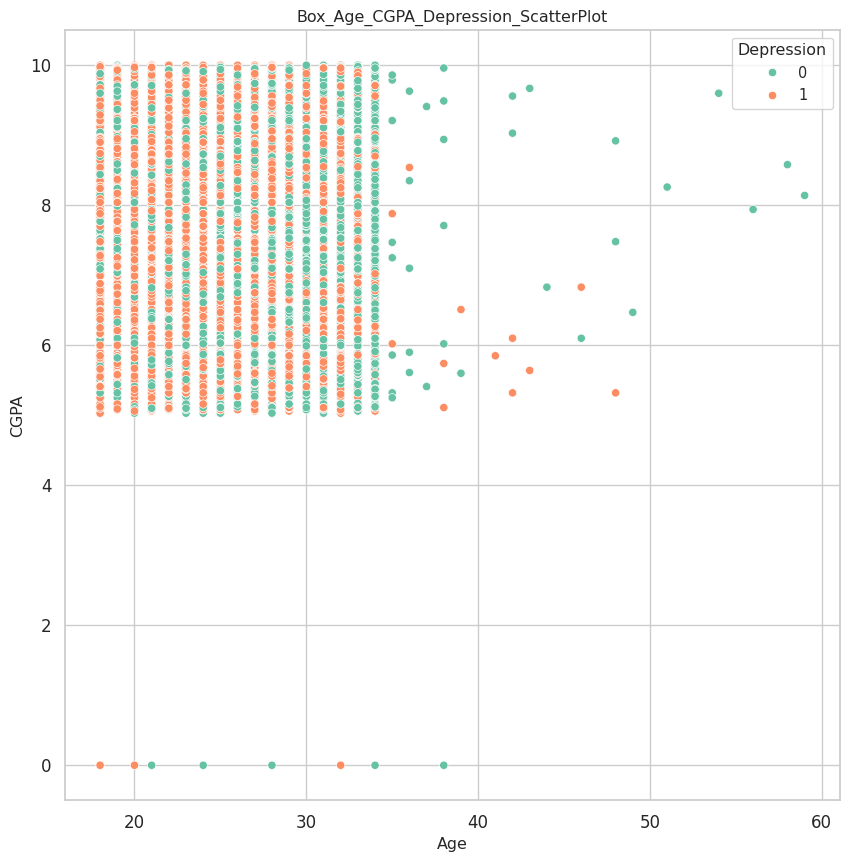

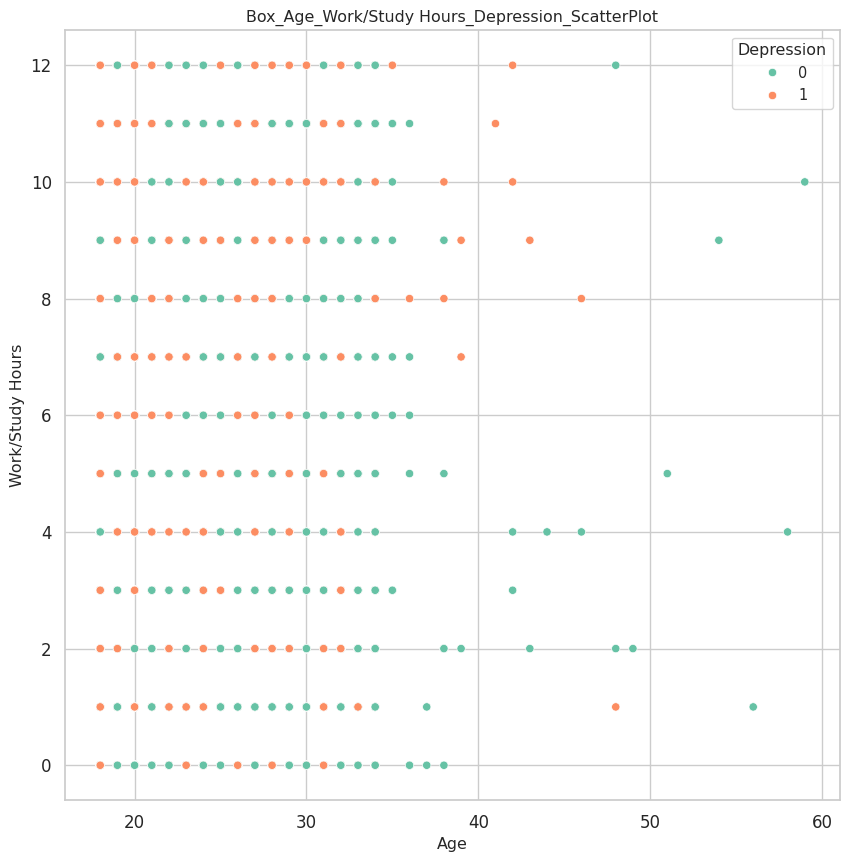

In [156]:
# Visual before cleaning data

f_get_heatmap_plot(df_temp, 'Before cleaning')

lst_show = ['Age', 'Work Pressure', 'CGPA',  'Work/Study Hours']
for _ in lst_show:
    f_get_hist_plot(df_temp, str(_))

for _ in lst_show:
    if _ != "Age":
        f_get_scatter_plot(df_temp, x='Age', y=_, hue='Depression', details='ScatterPlot')


In [157]:
''' Change type for non numeric columns '''
lst_category_upd = lst_category_init
df_temp = f_change_column_type(df_temp, lst_category_upd, pd.StringDtype())
df_temp = f_string_manipulation(df_temp, lst_category_upd, 'lower')

In [158]:
''' Clean column 'Sleep Duration' '''
df_temp = f_replace_value(df_temp, ['Sleep Duration'], '5-6 hours', 'A')
df_temp = f_replace_value(df_temp, ['Sleep Duration'], '7-8 hours', 'B')
df_temp = f_replace_value(df_temp, ['Sleep Duration'], 'less than 5 hours', 'C')
df_temp = f_replace_value(df_temp, ['Sleep Duration'], 'more than 8 hours', 'D')
df_temp = f_replace_value(df_temp, ['Sleep Duration'], 'others', 'E')
df_temp = f_filter_rows_2(df_temp, 'Sleep Duration', 'E', 'drop')

<ipython-input-151-8015a8a2a44f>:166: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_out[_].replace(value_old, value_new, inplace=True, regex=True)


In [159]:
''' Clean column 'Financial Stress' '''
lst_drop = [22377, 68910, 97610]
for _ in lst_drop:
    df_temp = f_filter_rows_2(df_temp, 'id', _, 'drop')

In [160]:
''' Clean column 'Academic Pressure' '''
df_temp = f_filter_rows_2(df_temp, 'Academic Pressure', 0, 'drop')

In [161]:
''' Clean column 'Work Pressure' '''
lst_drop = [2, 5]
for _ in lst_drop:
    df_temp = f_filter_rows_2(df_temp, 'Work Pressure', _, 'drop')

In [162]:
''' Clean column 'Study Satisfaction' '''
df_temp = f_filter_rows_2(df_temp, 'Study Satisfaction', 0, 'drop')

In [163]:
''' Clean column 'Job Satisfaction' '''
lst_drop = [1, 2, 3, 4]
for _ in lst_drop:
    df_temp = f_filter_rows_2(df_temp, 'Job Satisfaction', _, 'drop')

In [164]:
''' Clean column 'Dietary Habits' '''
df_temp = f_filter_rows_2(df_temp, 'Dietary Habits', 'others', 'drop')

In [165]:
''' Clean column 'Degree' '''
df_temp = f_filter_rows_2(df_temp, 'Degree', 'others', 'drop')

In [166]:
''' Data encoding '''
df_temp = f_encode_onehot_pd(df_temp, ['Gender', 'Have you ever had suicidal thoughts ?',
                                                    'Family History of Mental Illness'])
df_temp = f_encode_binary_labels(df_temp, ['City', 'Profession',
                                                        'Sleep Duration', 'Degree', 'Dietary Habits', ])

In [167]:
''' Data normalization '''
df_temp = f_normalize_min_max(df_temp, ['Age', 'Academic Pressure', 'Academic Pressure', 'CGPA',
                                                     'Study Satisfaction', 'Work/Study Hours', 'Financial Stress'])

In [168]:
''' Change columns name'''
df_temp = f_change_column_name_register(df_temp, str)

In [169]:
df_ml = df_temp.copy()
X = df_ml.drop(['depression'], axis=1)
y = df_ml['depression']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape X_train setelah preprocessing: {X_train.shape}")

Shape X_train setelah preprocessing: (22255, 115)


In [170]:
# 1. Arsitektur Model yang Ditingkatkan
model = tf.keras.Sequential([
    # Input layer sekarang akan otomatis menggunakan shape yang benar (137 fitur)
    tf.keras.layers.Input(shape=(X_train.shape[1],)),

    # ... sisa arsitektur Anda yang sudah diperbaiki ...
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [171]:
# 2. Compile Model
# Menggunakan learning rate awal yang sedikit lebih kecil
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,937 (93.50 KB)

 Trainable params: 23,553 (92.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [172]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Hitung bobot kelas dari data training
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight = {i : weights[i] for i in range(len(weights))}
print(f"Class Weights yang akan digunakan: {class_weight}")

Class Weights yang akan digunakan: {0: np.float64(1.2099054039360662), 1: np.float64(0.8521595956501762)}


In [173]:
# Definisikan Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [174]:
# 4. Latih Model dengan Callbacks dan Class Weight
history = model.fit(
    X_train.astype('float32'),
    y_train.astype('float32'),
    epochs=50, # Kita bisa set lebih tinggi, EarlyStopping akan berhenti otomatis
    validation_data=(X_test.astype('float32'), y_test.astype('float32')),
    class_weight=class_weight, # PENTING: Untuk menangani data tidak seimbang
    callbacks=[reduce_lr, early_stopping] # PENTING: Untuk training yang lebih cerdas
)

Epoch 1/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5059 - loss: 0.8431 - val_accuracy: 0.4193 - val_loss: 0.7597 - learning_rate: 0.0010
Epoch 2/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4804 - loss: 0.7577 - val_accuracy: 0.5442 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 3/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5083 - loss: 0.7266 - val_accuracy: 0.4856 - val_loss: 0.7176 - learning_rate: 0.0010
Epoch 4/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5094 - loss: 0.7114 - val_accuracy: 0.5564 - val_loss: 0.7017 - learning_rate: 0.0010
Epoch 5/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4900 - loss: 0.7038 - val_accuracy: 0.5066 - val_loss: 0.7000 - learning_rate: 0.0010
Epoch 6/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5071 - loss: 0.7000 - val_accuracy: 0.4840 - val_loss: 0.6951 - learning_rate: 0.0010
Epoch 7/50
696/696 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5033 - loss: 0.6967 - 

In [175]:
# ================================================================
# BAGIAN 4: EVALUASI MODEL (KOREKSI)
# ================================================================
# Evaluasi pada data test
loss, accuracy = model.evaluate(X_test.astype('float32'), y_test.astype('float32'))
print(f'\nHasil Evaluasi Baru:')
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5724 - loss: 0.6905

Hasil Evaluasi Baru:
Test Loss: 0.6900
Test Accuracy: 58.07%


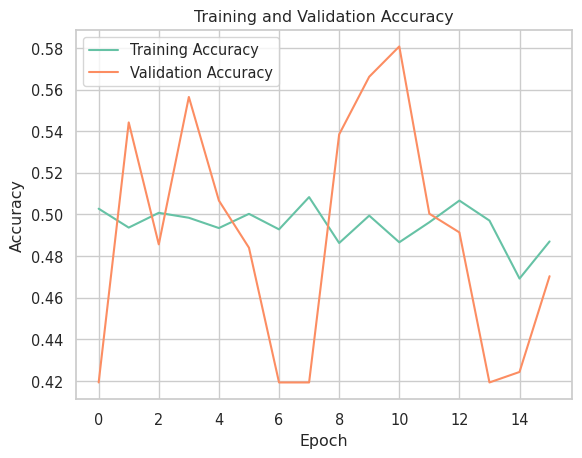

In [176]:
# Anda juga bisa membuat plot akurasi dan loss dari history training
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [177]:
# ================================================================
# BAGIAN 5: INFERENSI SEDERHANA (TAMBAHAN BARU)
# ================================================================
# Menggunakan satu data sampel untuk prediksi
sample_index = 50
sample_data = X_test.iloc[sample_index:sample_index+1].astype('float32')
actual_label = y_test.iloc[sample_index]

prediction = model.predict(sample_data)
predicted_probability = prediction[0][0]
predicted_class = 1 if predicted_probability > 0.5 else 0

print(f"\n--- Proses Inferensi ---")
print(f"Probabilitas Prediksi: {predicted_probability:.4f}")
print(f"Hasil Prediksi: Kelas {predicted_class}")
print(f"Label Sebenarnya: Kelas {actual_label}")
print("------------------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

--- Proses Inferensi ---
Probabilitas Prediksi: 0.5140
Hasil Prediksi: Kelas 1
Label Sebenarnya: Kelas 1
------------------------


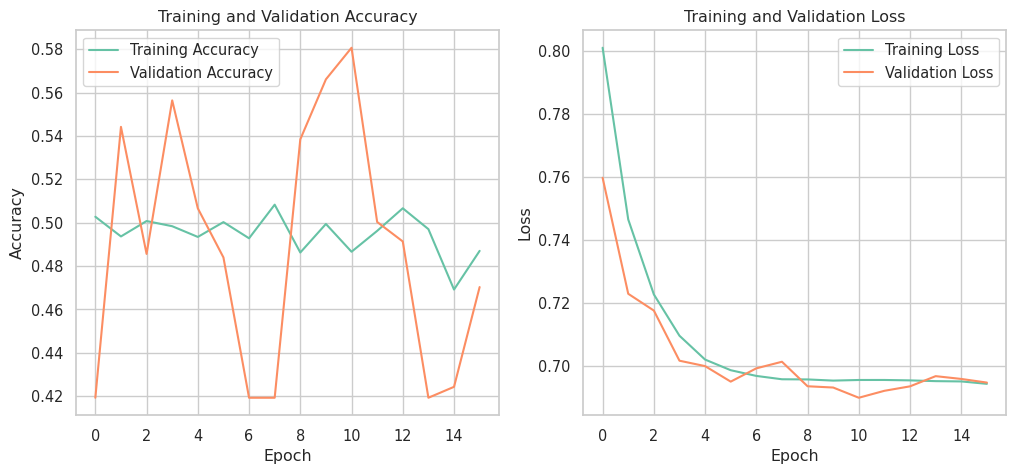

In [178]:
## Plot Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()